# GTZAN Redes Neuronales

In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2 #pip install opencv-python
from sklearn.metrics import confusion_matrix, f1_score
from scipy.optimize import minimize
import librosa                    
import librosa.display
import itertools
from sklearn.preprocessing import normalize

## Images

In [50]:
IMG = './data/images_original/'
#IMG = './dataset/'
img_dataset = []
genre_target = []
genres = {}
classes = []
i = 0
for root, dirs, files in os.walk(IMG):
    for name in files:
        filename = os.path.join(root, name)
        img_dataset.append(filename)
        genre = filename.split('\\')[0].split('/')[-1]
        genre_target.append(genre)
        
        if(genre not in genres):
            classes.append(genre)
            genres[genre] = i
            i+=1

In [51]:
print(genres)
print(classes)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [52]:
np.shape(img_dataset)

(999,)

In [53]:
np.shape(genre_target)

(999,)

In [54]:
def crop_borders(img,x1=35,x2=252,y1=54,y2=389):
    cropped = img[x1:x2,y1:y2]
    return cropped

In [55]:
def get_y(): 
    '''Convierte los generos en un array de targets y'''
    y = []
    for genre in genre_target:
        #OneHot encoding?
        n = genres[genre]
        y.append(n)
    return np.array(y)

def one_hot(y, m, num_labels):
    '''one hot encoding'''
    y_onehot = np.zeros((m, num_labels))
    for i in range(m):
        y_onehot[i][y[i]] = 1
    return y_onehot

def get_x(shape=[999,217*335], flag=0):
    '''Covierte las imagenes en arrays'''
    x = np.empty(shape, np.uint8)
    for i in range(len(img_dataset)):
        img = cv2.imread(img_dataset[i],flag)
        img = crop_borders(img)
        x[i] = img.ravel()
    return np.array(x)

In [56]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x)*(1 - sigmoid(x))

def pesosAleatorios(L_in, L_out):
    ini_epsilon = 0.12
    theta = np.random.rand(L_out, 1 + L_in) * (2*ini_epsilon) - ini_epsilon 
    return theta

def forward_propagation(X, theta1, theta2):
    '''Funcion de propagación hacia delante para red neuronal de 3 capas'''
    m = X.shape[0]
    a1 = np.hstack([np.ones([m, 1]), X]) 
    z2 = np.dot(a1, theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid(z2)])
    z3 = np.dot(a2, theta2.T)
    h = sigmoid(z3)
    return a1, z2, a2, z3, h

def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg=0):
    '''Funcion de back-propagation para red neuronal de 3 capas''' 
    m = X.shape[0]
    
    # Desplegamos los paramas_rn en la matrices Theta
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)],
                       (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):],
                       (num_etiquetas, (num_ocultas + 1)))
    
    # Aplicamos forward-propagation para calcular la salidas de cada capa
    a1, z2, a2, z3, h = forward_propagation(X, theta1, theta2)
    
    # Calculo del coste
    cost = 0
    for i in range(m):
        a = np.dot(-y[i,:], np.log(h[i,:]))
        b = np.dot((1-y[i,:]), np.log(1-h[i,:]))
        cost += np.sum(a - b)
        
    cost = cost/m
    
    # Regularizacion del coste
    cost += reg/(2*m) * (np.sum(theta1[:, 1:]**2) + np.sum(theta2[:, 1:]**2))
    
    # Back-propagation
    delta1 = np.zeros(theta1.shape)
    delta2 = np.zeros(theta2.shape)
    
    for t in range(m):
        a1t = a1[t,:]
        a2t = a2[t,:]
        ht = h[t,:]
        yt = y[t]
        
        d3 = ht - yt
        d2 = np.dot(theta2.T, d3) * (a2t * (1 - a2t))
        
        delta1 += np.dot(d2[1:, np.newaxis], a1t[np.newaxis, :])
        delta2 += np.dot(d3[:, np.newaxis], a2t[np.newaxis, :])
        
    # Calculo del gradiente
    D1 = delta1 / m
    D2 = delta2 / m
    
    # Regularizacion del gradiente
    D1[:, 1:] = D1[:, 1:] + (reg * theta1[:, 1:]) / m
    D2[:, 1:] = D2[:, 1:] + (reg * theta2[:, 1:]) / m
    
    gradient = np.concatenate((np.ravel(D1), np.ravel(D2)))
    
    return cost, gradient

In [57]:
X = get_x()
y = get_y()
y_onehot = one_hot(y, len(y), len(genres))

print(X.shape, y.shape, y_onehot.shape)

(999, 72695) (999,) (999, 10)


In [58]:
import scipy.optimize as opt

def train(X, y, num_labels, hidden_size, reg, iters):
    num_entradas = X.shape[1]
    num_ocultas = hidden_size
    num_etiquetas = num_labels

    theta1 = pesosAleatorios(num_entradas, num_ocultas)
    theta2 = pesosAleatorios(num_ocultas, num_etiquetas)
    params = np.concatenate((np.ravel(theta1), np.ravel(theta2)))

    fmin = opt.minimize(fun=backprop, x0=params, 
                 args=(num_entradas, num_ocultas, num_etiquetas, X, y, reg),
                 method='TNC', jac=True, options={'maxiter' : iters})

    theta1 = np.reshape(fmin.x[:num_ocultas * (num_entradas + 1)],
                       (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(fmin.x[num_ocultas * (num_entradas + 1):],
                       (num_etiquetas, (num_ocultas + 1)))

    a1, z2, a2, z2, h = forward_propagation(X, theta1, theta2)

    predictions = np.argmax(h, axis=1)
    return predictions

In [59]:
predictions = train(X, y_onehot, num_labels=len(genres), hidden_size=25, reg=1, iters=70)

In [58]:
fallos =  np.where([predictions != y])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y)
print("\nPorcentaje de aciertos: ", accuracy)

Numero de fallos: 897
Numero de aciertos: 102

Porcentaje de aciertos:  10.21021021021021


In [60]:
predictions = train(X, y_onehot, num_labels=len(genres), hidden_size=25, reg=0.1, iters=70)

fallos =  np.where([predictions != y])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y)
print("\nPorcentaje de aciertos: ", accuracy)

Numero de fallos: 814
Numero de aciertos: 185

Porcentaje de aciertos:  18.51851851851852


In [61]:
predictions = train(X, y_onehot, num_labels=len(genres), hidden_size=25, reg=0.1, iters=110)

fallos =  np.where([predictions != y])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y)
print("\nPorcentaje de aciertos: ", accuracy)

Numero de fallos: 861
Numero de aciertos: 138

Porcentaje de aciertos:  13.813813813813812


In [62]:
predictions = train(X, y_onehot, num_labels=len(genres), hidden_size=50, reg=0.1, iters=70)

fallos =  np.where([predictions != y])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y)
print("\nPorcentaje de aciertos: ", accuracy)

Numero de fallos: 809
Numero de aciertos: 190

Porcentaje de aciertos:  19.01901901901902


In [11]:
predictions = train(X, y_onehot, num_labels=len(genres), hidden_size=100, reg=0.1, iters=100)

fallos =  np.where([predictions != y])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y)
print("\nPorcentaje de aciertos: ", accuracy)

Numero de fallos: 816
Numero de aciertos: 183

Porcentaje de aciertos:  18.31831831831832


In [12]:
predictions = train(X, y_onehot, num_labels=len(genres), hidden_size=100, reg=1, iters=100)

fallos =  np.where([predictions != y])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y)
print("\nPorcentaje de aciertos: ", accuracy)

C:\Users\Pablo\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


Numero de fallos: 824
Numero de aciertos: 175

Porcentaje de aciertos:  17.51751751751752


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, = train_test_split(X, y, stratify=y, random_state=42)

print(X_test.shape, X_train.shape)

(250, 72695) (749, 72695)


In [56]:
y_train_onehot = one_hot(y_train, len(y_train), len(genres))

In [65]:
predictions = train(X_train, y_train_onehot, X_test, num_labels=len(genres), hidden_size=25, reg=0.1, iters=70)

fallos =  np.where([predictions != y_test])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y_test])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y_test)
print("\nPorcentaje de aciertos: ", accuracy)

Numero de fallos: 208
Numero de aciertos: 42

Porcentaje de aciertos:  16.8


In [66]:
def multiple_train(X_train, y_train, X_test, num_labels, hidden_size, reg_params, iters):
    for reg in reg_params:
        print("Training, REG=", reg)
        predictions = train(X_train, y_train, X_test, num_labels, hidden_size, reg, iters)
        
        fallos =  np.where([predictions != y_test])[1]
        print('\tNumero de fallos:', len(fallos))

        aciertos = np.where([predictions == y_test])[1]
        print('\tNumero de aciertos:', len(aciertos))

        accuracy = 100 * np.mean(predictions == y_test)
        print("\n\tPorcentaje de aciertos: ", accuracy)
        
reg_params = [0, 0.1, 0.3, 0.5, 1, 3]
multiple_train(X_train, y_train_onehot, X_test, num_labels=len(genres), hidden_size=25, reg_params=reg_params, iters=70)

Training, REG= 0
	Numero de fallos: 204
	Numero de aciertos: 46

	Porcentaje de aciertos:  18.4
Training, REG= 0.1
	Numero de fallos: 224
	Numero de aciertos: 26

	Porcentaje de aciertos:  10.4
Training, REG= 0.3
	Numero de fallos: 207
	Numero de aciertos: 43

	Porcentaje de aciertos:  17.2
Training, REG= 0.5
	Numero de fallos: 222
	Numero de aciertos: 28

	Porcentaje de aciertos:  11.200000000000001
Training, REG= 1
	Numero de fallos: 223
	Numero de aciertos: 27

	Porcentaje de aciertos:  10.8
Training, REG= 3
	Numero de fallos: 218
	Numero de aciertos: 32

	Porcentaje de aciertos:  12.8


In [68]:
predictions = train(X, y_onehot, X, num_labels=len(genres), hidden_size=25, reg=0, iters=70)

fallos =  np.where([predictions != y])[1]
print('Numero de fallos:', len(fallos))

aciertos = np.where([predictions == y])[1]
print('Numero de aciertos:', len(aciertos))

accuracy = 100 * np.mean(predictions == y)
print("\nPorcentaje de aciertos: ", accuracy)

Numero de fallos: 842
Numero de aciertos: 157

Porcentaje de aciertos:  15.715715715715717


#### - MLP Sklearn:

In [101]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=200, alpha=0.001, activation='relu', random_state=42)

mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [103]:
mlp.score(X_train, y_train)

0.10013351134846461

In [112]:
predictions = []
train_scores = []
test_scores = []

layers = [(25,), (25, 25), (25,25,25), (50,), (50,50), (50,50,50), (100,), (100,100), (100,100,100)]
regul = [0.0001, 0.01, 0.1, 0.3, 1]
for l in layers:
    for r in regul:
        print('Training MLP layers: {}, alpha: {}...'.format(l, r))
        mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=300, alpha=r, activation='relu', solver='adam', random_state=42)

        mlp.fit(X_train, y_train)

        prediction = mlp.predict(X_test)
        test_score = mlp.score(X_test, y_test)
        train_score = mlp.score(X_train, y_train)

        print('\t Train accuracy: ', train_score)
        print('\t Test accuracy: ', test_score)

        predictions.append(prediction)
        test_scores.append(test_score)
        train_scores.append(train_score)

Training MLP layers: (25,), alpha: 0.0001...
	 Train accuracy:  0.10013351134846461
	 Test accuracy:  0.1
Training MLP layers: (25,), alpha: 0.01...
	 Train accuracy:  0.10013351134846461
	 Test accuracy:  0.1
Training MLP layers: (25,), alpha: 0.1...
	 Train accuracy:  0.09879839786381843
	 Test accuracy:  0.1
Training MLP layers: (25,), alpha: 0.3...
	 Train accuracy:  0.09879839786381843
	 Test accuracy:  0.1
Training MLP layers: (25,), alpha: 1...
	 Train accuracy:  0.09879839786381843
	 Test accuracy:  0.1
Training MLP layers: (25, 25), alpha: 0.0001...
	 Train accuracy:  0.10013351134846461
	 Test accuracy:  0.1
Training MLP layers: (25, 25), alpha: 0.01...
	 Train accuracy:  0.10013351134846461
	 Test accuracy:  0.1
Training MLP layers: (25, 25), alpha: 0.1...
	 Train accuracy:  0.10013351134846461
	 Test accuracy:  0.1
Training MLP layers: (25, 25), alpha: 0.3...


C:\Users\Pablo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 Train accuracy:  0.16955941255006676
	 Test accuracy:  0.156
Training MLP layers: (25, 25), alpha: 1...
	 Train accuracy:  0.09879839786381843
	 Test accuracy:  0.096
Training MLP layers: (25, 25, 25), alpha: 0.0001...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.384
Training MLP layers: (25, 25, 25), alpha: 0.01...
	 Train accuracy:  0.9946595460614153
	 Test accuracy:  0.356
Training MLP layers: (25, 25, 25), alpha: 0.1...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.356
Training MLP layers: (25, 25, 25), alpha: 0.3...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.356
Training MLP layers: (25, 25, 25), alpha: 1...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.372
Training MLP layers: (50,), alpha: 0.0001...
	 Train accuracy:  0.102803738317757
	 Test accuracy:  0.1
Training MLP layers: (50,), alpha: 0.01...
	 Train accuracy:  0.102803738317757
	 Test accuracy:  0.1
Training MLP layers: (50,), alpha: 0.1...
	 Train accuracy:  0.10146

C:\Users\Pablo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 Train accuracy:  0.10013351134846461
	 Test accuracy:  0.1
Training MLP layers: (50, 50), alpha: 1...


C:\Users\Pablo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 Train accuracy:  0.10013351134846461
	 Test accuracy:  0.1
Training MLP layers: (50, 50, 50), alpha: 0.0001...
	 Train accuracy:  0.9946595460614153
	 Test accuracy:  0.28
Training MLP layers: (50, 50, 50), alpha: 0.01...
	 Train accuracy:  0.9599465954606141
	 Test accuracy:  0.312
Training MLP layers: (50, 50, 50), alpha: 0.1...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.288
Training MLP layers: (50, 50, 50), alpha: 0.3...
	 Train accuracy:  0.9345794392523364
	 Test accuracy:  0.276
Training MLP layers: (50, 50, 50), alpha: 1...
	 Train accuracy:  0.10146862483311081
	 Test accuracy:  0.1
Training MLP layers: (100,), alpha: 0.0001...
	 Train accuracy:  0.2656875834445928
	 Test accuracy:  0.188
Training MLP layers: (100,), alpha: 0.01...
	 Train accuracy:  0.19759679572763686
	 Test accuracy:  0.164
Training MLP layers: (100,), alpha: 0.1...
	 Train accuracy:  0.1041388518024032
	 Test accuracy:  0.1
Training MLP layers: (100,), alpha: 0.3...
	 Train accuracy:  0.10

C:\Users\Pablo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 Train accuracy:  0.17623497997329773
	 Test accuracy:  0.168
Training MLP layers: (100, 100), alpha: 0.0001...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.424
Training MLP layers: (100, 100), alpha: 0.01...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.424
Training MLP layers: (100, 100), alpha: 0.1...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.38
Training MLP layers: (100, 100), alpha: 0.3...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.424
Training MLP layers: (100, 100), alpha: 1...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.448
Training MLP layers: (100, 100, 100), alpha: 0.0001...
	 Train accuracy:  0.9813084112149533
	 Test accuracy:  0.364
Training MLP layers: (100, 100, 100), alpha: 0.01...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.424
Training MLP layers: (100, 100, 100), alpha: 0.1...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.412
Training MLP layers: (100, 100, 100), alpha: 

In [131]:
mlp = MLPClassifier(hidden_layer_sizes=(500,), max_iter=300, alpha=0.1, activation='relu', solver='adam', random_state=42)

mlp.fit(X_train, y_train)

prediction = mlp.predict(X_test)
test_score = mlp.score(X_test, y_test)
train_score = mlp.score(X_train, y_train)

print('\t Train accuracy: ', train_score)
print('\t Test accuracy: ', test_score)

	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.476


In [132]:
layers = [(500,), (500, 500), (1000,)]
regul = [0.1, 0.3, 1]
for l in layers:
    for r in regul:
        print('Training MLP layers: {}, alpha: {}...'.format(l, r))
        mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=300, alpha=r, activation='relu', solver='adam', random_state=42)

        mlp.fit(X_train, y_train)

        prediction = mlp.predict(X_test)
        test_score = mlp.score(X_test, y_test)
        train_score = mlp.score(X_train, y_train)

        print('\t Train accuracy: ', train_score)
        print('\t Test accuracy: ', test_score)

Training MLP layers: (500,), alpha: 0.1...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.476
Training MLP layers: (500,), alpha: 0.3...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.432
Training MLP layers: (500,), alpha: 1...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.42
Training MLP layers: (500, 500), alpha: 0.1...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.448
Training MLP layers: (500, 500), alpha: 0.3...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.424
Training MLP layers: (500, 500), alpha: 1...
	 Train accuracy:  0.8891855807743658
	 Test accuracy:  0.396
Training MLP layers: (1000,), alpha: 0.1...
	 Train accuracy:  0.9826435246995995
	 Test accuracy:  0.38
Training MLP layers: (1000,), alpha: 0.3...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.468
Training MLP layers: (1000,), alpha: 1...
	 Train accuracy:  0.9986648865153538
	 Test accuracy:  0.408


In [134]:
mlp = MLPClassifier(hidden_layer_sizes=(500,), max_iter=300, alpha=0.1, activation='relu', solver='adam', random_state=42)

mlp.fit(X_train, y_train)

In [139]:
prediction = mlp.predict(X_test)
score = mlp.score(X_test, y_test)
print('Test Accuracy: ', score)

Test Accuracy:  0.476


In [26]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genres))
    plt.xticks(tick_marks, genres, rotation=45)
#     plt.yticks(tick_marks, genres)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [159]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(prediction, y_test)

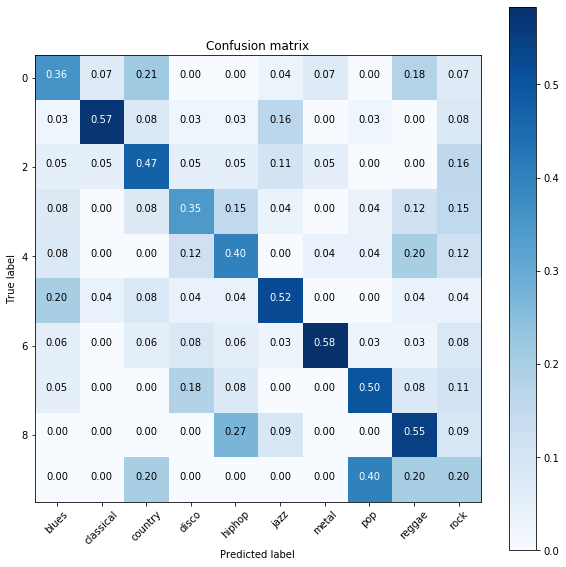

In [218]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [228]:
files = os.listdir('./test_songs/images/')
songs = ['./test_songs/images/'+img for img in files if img.split('.')[-1] == 'png']

for song in songs:
    img = cv2.imread(song,0)
    #img = crop_borders(img)
    #img = crop_borders(img,x1=50,x2=252,y1=144,y2=244)
    #img = extract_features(song)
    mel = img.ravel()
    pred = mlp.predict(mel.reshape(1, -1))
    print(song,'--> ' ,classes[int(pred)])

./test_songs/images/abba.png -->  disco
./test_songs/images/desakato.png -->  pop
./test_songs/images/elfinde.png -->  disco
./test_songs/images/iseo.png -->  hiphop
./test_songs/images/marley.png -->  pop
./test_songs/images/metallica.png -->  metal
./test_songs/images/requiem.png -->  classical
./test_songs/images/sultans.png -->  country
./test_songs/images/wutang.png -->  disco


## Features (features 30 sec)

In [39]:
data = pd.read_csv('./data/features_30_sec.csv', header=None).values
data = data[1:, 1:]

print(data.shape)

X = np.array(data[:, :-1])
print(np.shape(X))

y = np.array(data[:, -1])
print(np.shape(y))

y_onehot = np.zeros((len(y), len(genres)))
for i in range(len(y)):
    pos = genres.get(y[i])
    y_onehot[i][pos] = 1
    
print(y_onehot.shape)

m = np.shape(X)[0]
n = np.shape(X)[1]

(1000, 59)
(1000, 58)
(1000,)
(1000, 10)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, = train_test_split(X, y, stratify=y, random_state=42)

print(X_train.shape, X_test.shape)

(750, 58) (250, 58)


In [19]:
pred = []
trn_scor = []
tst_scor = []

layers = [(25,), (25, 25), (25,25,25), (50,), (50,50), (50,50,50), (100,), (100,100), (100,100,100), (500,), (500, 500), (1000, )]
regul = [0.0001, 0.01, 0.1, 0.3, 1]
for l in layers:
    for r in regul:
        print('Training MLP layers: {}, alpha: {}...'.format(l, r))
        mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, alpha=r, activation='relu', solver='adam', random_state=42)

        mlp.fit(X_train, y_train)

        prediction = mlp.predict(X_test)
        test_score = mlp.score(X_test, y_test)
        train_score = mlp.score(X_train, y_train)

        print('\t Train accuracy: ', train_score)
        print('\t Test accuracy: ', test_score)

        pred.append(prediction)
        tst_scor.append(test_score)
        trn_scor.append(train_score)

Training MLP layers: (25,), alpha: 0.0001...
	 Train accuracy:  0.632
	 Test accuracy:  0.484
Training MLP layers: (25,), alpha: 0.01...
	 Train accuracy:  0.6453333333333333
	 Test accuracy:  0.548
Training MLP layers: (25,), alpha: 0.1...
	 Train accuracy:  0.5866666666666667
	 Test accuracy:  0.484
Training MLP layers: (25,), alpha: 0.3...
	 Train accuracy:  0.6786666666666666
	 Test accuracy:  0.536
Training MLP layers: (25,), alpha: 1...
	 Train accuracy:  0.6666666666666666
	 Test accuracy:  0.528
Training MLP layers: (25, 25), alpha: 0.0001...
	 Train accuracy:  0.592
	 Test accuracy:  0.52
Training MLP layers: (25, 25), alpha: 0.01...
	 Train accuracy:  0.5413333333333333
	 Test accuracy:  0.432
Training MLP layers: (25, 25), alpha: 0.1...
	 Train accuracy:  0.5653333333333334
	 Test accuracy:  0.424
Training MLP layers: (25, 25), alpha: 0.3...
	 Train accuracy:  0.47333333333333333
	 Test accuracy:  0.412
Training MLP layers: (25, 25), alpha: 1...
	 Train accuracy:  0.49466666

In [25]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100000, alpha=0.1, activation='relu', solver='adam', random_state=42)

mlp.fit(X_train, y_train)

prediction = mlp.predict(X_test)
test_score = mlp.score(X_test, y_test)
train_score = mlp.score(X_train, y_train)

print('\t Train accuracy: ', train_score)
print('\t Test accuracy: ', test_score)

	 Train accuracy:  0.808
	 Test accuracy:  0.588


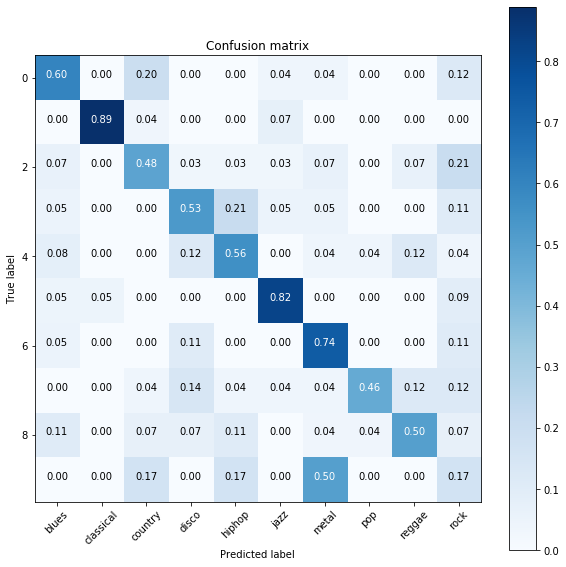

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(prediction, y_test)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

## Añadir mas Features (gtzan features)

In [42]:
import pandas as pd

data = pd.read_csv('./data/gtzan_features.csv', header=None).values
data = data[1:, :]

print(data.shape)

X = np.array(data[:, :-1])
print(np.shape(X))

y = np.array(data[:, -1])
print(np.shape(y))

m = np.shape(X)[0]
n = np.shape(X)[1]

data

(999, 134)
(999, 133)
(999,)


array([['4053.9856728037425', '925.9340828377008', '1727.3818070765265',
        ..., '-0.02497577335879588', '123.046875', '0'],
       ['5430.12246088078', '372.72896065815553', '1450.8385225950005',
        ..., '-0.03709436745872319', '107.666015625', '0'],
       ['4709.894987472859', '356.7356446956628', '1493.9254357661255',
        ..., '0.5446035881446988', '161.4990234375', '0'],
       ...,
       ['4295.2918925305585', '746.2169891187394', '2016.655015607242',
        ..., '0.15532153043740446', '129.19921875', '9'],
       ['4151.205943640898', '463.39159957509355', '1314.911488967608',
        ..., '-0.1484556321387929', '112.34714673913044', '9'],
       ['3900.0128108850795', '360.75444529480313', '1505.409168527501',
        ..., '0.10454844625266736', '123.046875', '9']], dtype=object)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, = train_test_split(X, y, stratify=y, random_state=42)

print(X_train.shape, X_test.shape)

(749, 132) (250, 132)


In [24]:
layers = [(25,), (25, 25), (25,25,25), (50,), (50,50), (50,50,50), (100,), (100,100), (100,100,100), (500,), (500, 500), (1000, )]
regul = [0.0001, 0.01, 0.1, 0.3, 1]
for l in layers:
    for r in regul:
        print('Training MLP layers: {}, alpha: {}...'.format(l, r))
        mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, alpha=r, activation='relu', solver='adam', random_state=42)

        mlp.fit(X_train, y_train)

        prediction = mlp.predict(X_test)
        test_score = mlp.score(X_test, y_test)
        train_score = mlp.score(X_train, y_train)

        print('\t Train accuracy: ', train_score)
        print('\t Test accuracy: ', test_score)

Training MLP layers: (25,), alpha: 0.0001...
	 Train accuracy:  0.5327102803738317
	 Test accuracy:  0.46
Training MLP layers: (25,), alpha: 0.01...
	 Train accuracy:  0.49666221628838453
	 Test accuracy:  0.44
Training MLP layers: (25,), alpha: 0.1...
	 Train accuracy:  0.514018691588785
	 Test accuracy:  0.436
Training MLP layers: (25,), alpha: 0.3...
	 Train accuracy:  0.5046728971962616
	 Test accuracy:  0.444
Training MLP layers: (25,), alpha: 1...
	 Train accuracy:  0.5113484646194927
	 Test accuracy:  0.436
Training MLP layers: (25, 25), alpha: 0.0001...
	 Train accuracy:  0.5473965287049399
	 Test accuracy:  0.484
Training MLP layers: (25, 25), alpha: 0.01...
	 Train accuracy:  0.5393858477970628
	 Test accuracy:  0.476
Training MLP layers: (25, 25), alpha: 0.1...
	 Train accuracy:  0.5580774365821095
	 Test accuracy:  0.46
Training MLP layers: (25, 25), alpha: 0.3...
	 Train accuracy:  0.5607476635514018
	 Test accuracy:  0.468
Training MLP layers: (25, 25), alpha: 1...
	 Trai

In [47]:
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100000, alpha=0.3, activation='relu', solver='adam', random_state=42)

mlp.fit(X_train, y_train)

prediction = mlp.predict(X_test)
test_score = mlp.score(X_test, y_test)
train_score = mlp.score(X_train, y_train)

print('\t Train accuracy: ', train_score)
print('\t Test accuracy: ', test_score)

	 Train accuracy:  0.5447263017356475
	 Test accuracy:  0.504


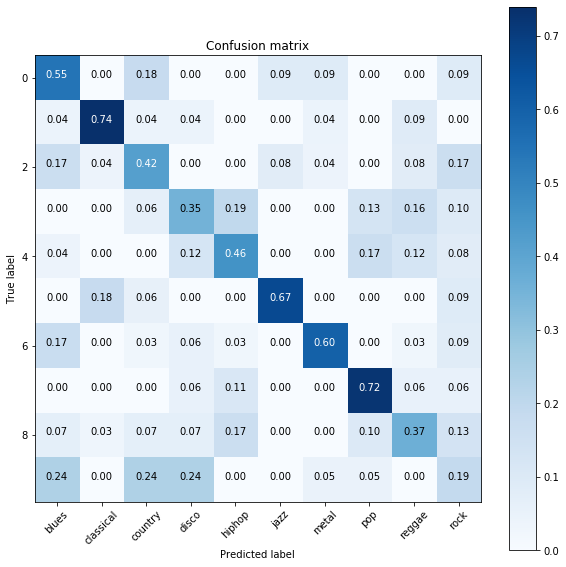

In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(prediction, y_test)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)